# U-net architecture and training

## Select model type, data, number of epochs and training step multiplier (user input required)
### Select the model
If pretrained model is selected, use_onehot_masks is forced to False

In [1]:
selected_model = int(input("Select U-net type: [0] = U-net from Scratch, [1] = Down Convolution with MobileNetV2, [2] = Down Convolution with VGG16:"))

if selected_model == 0:
    pretrained_model = 'U-net-from-scratch'
    use_onehot_masks = True
    print('Running U-net from scratch without a pretrained model')
elif selected_model == 1:
    pretrained_model = 'MobileNetV2'
    use_onehot_masks = False
    print('Running U-net with', pretrained_model, 'as pretrained model in the down convolution path')
elif selected_model == 2:
    pretrained_model = 'VGG16'
    use_onehot_masks = False
    print('Running U-net with', pretrained_model, 'as pretrained model in the down convolution path')

Select U-net type: [0] = U-net from Scratch, [1] = Down Convolution with MobileNetV2, [2] = Down Convolution with VGG16: 0


Running U-net from scratch without a pretrained model


### Select cell type for model input (only cort, shsy5y or astro or all 3 types)

In [2]:
cell_types = ["astro", "shsy5y", "cort"]

which_cell_id = int(input("Select mask type: [0] = All, [1] = astro, [2] = shsy5y, [3] = cort, 0, 1, 2 or 3:")) # 0 = ALL; 1 id starts with first unique cell_type

if which_cell_id == 0:
    which_cell = 'all'
    print('Running U-net with', which_cell, 'data')
else:    
    which_cell = cell_types[which_cell_id-1]
    
    print('Running U-net with only', which_cell, 'data')

Select mask type: [0] = All, [1] = astro, [2] = shsy5y, [3] = cort, 0, 1, 2 or 3: 1


Running U-net with only astro data


### Select number of training epochs and training steps

In [3]:
n_epochs            = int(input("Number of epochs [integer > 0 or -1 for default of 25]:"))
TRAINING_STEPS_MULT = int(input("Training step multiplier [integer > 0 or -1 for default of 2]:"))

if n_epochs < 1:
    n_epochs = 25

if TRAINING_STEPS_MULT < 1:
    TRAINING_STEPS_MULT = 2
    
print(f"Train model with {n_epochs} epochs and {TRAINING_STEPS_MULT} fold training steps")

Number of epochs [integer > 0 or -1 for default of 25]: 2
Training step multiplier [integer > 0 or -1 for default of 2]: 1


Train model with 2 epochs and 1 fold training steps


## Imports and preparation
### Set the desired image size and number of channels of the segmentation mask (single channel versus one-hot encoding)

In [4]:
if use_onehot_masks is True:
    CHANNELS_MASK = 3
else:
    CHANNELS_MASK = 1

HEIGHT = 128
WIDTH = 128

with open('image_modeling.py', 'r') as infile:
    lines = infile.readlines()

lines.insert(0, f"HEIGHT = {HEIGHT}\n")
lines.insert(0, f"WIDTH = {WIDTH}\n")
lines.insert(0, f"CHANNELS_MASK = {CHANNELS_MASK}\n")
lines.insert(0, "\n")

with open('image_modeling_import.py', 'w') as outfile:
    outfile.writelines(lines)

### Imports

In [5]:
# Import required packages
import image_modeling_import   # import image_modeling_import.py file
import u_net_functions as unf

import pandas as pd
import datetime

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy

import segmentation_models as sm

from sklearn.model_selection import train_test_split

from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import regularizers

# Load the TensorBoard notebook extension
%load_ext tensorboard

from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

Segmentation Models: using `keras` framework.


In [6]:
# Clear any logs from previous runs
!rm -rf ./logs/

# Check for Tensorflow version
print(tf.__version__)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

# tf.keras.backend.clear_session()

2.8.0


#### Load csv files depending on the mask's number of channels

In [7]:
if which_cell_id == 0:
    if use_onehot_masks is True:
        TRAIN_PATH = 'CSVs/cells_train_oh.csv'
        EVAL_PATH  = 'CSVs/cells_eval_oh.csv'
        TEST_PATH  = 'CSVs/cells_test_oh.csv'
    
    else:
        TRAIN_PATH = 'CSVs/cells_train.csv'
        EVAL_PATH  = 'CSVs/cells_eval.csv'
        TEST_PATH  = 'CSVs/cells_test.csv'
else:
    if use_onehot_masks is True:
        TRAIN_PATH = 'CSVs/cells_train_oh_{}.csv'.format(which_cell)
        EVAL_PATH  = 'CSVs/cells_eval_oh_{}.csv'.format(which_cell)
        TEST_PATH  = 'CSVs/cells_test_oh_{}.csv'.format(which_cell)
    
    else:
        TRAIN_PATH = 'CSVs/cells_train_{}.csv'.format(which_cell)
        EVAL_PATH  = 'CSVs/cells_eval_{}.csv'.format(which_cell)
        TEST_PATH  = 'CSVs/cells_test_{}.csv'.format(which_cell)

#### Import variables from image_modelling.py file

In [8]:
HEIGHT = image_modeling_import.HEIGHT
WIDTH = image_modeling_import.WIDTH
BATCH_SIZE = image_modeling_import.BATCH_SIZE

# Training size depends on number of training samples
if which_cell_id == 0:
    TRAINING_SIZE = len(pd.read_csv('CSVs/cells_train.csv'))
    TRAINING_STEPS = int(TRAINING_SIZE) // BATCH_SIZE
else:
    TRAINING_SIZE = len(pd.read_csv('CSVs/cells_train_{}.csv'.format(which_cell)))
    TRAINING_STEPS = int(TRAINING_SIZE) // BATCH_SIZE
    


### Functions to display images, masks and predictions

In [9]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            model.predict(image)
            unf.display([image[0], mask[0], create_mask(pred_mask)])
    else:
        unf.display([sample_image, sample_mask,
                 unf.create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [10]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

### Function for training and evaluation (kept in this notebook for easier modification of number of epochs etc)

In [11]:
# Create a function for training and evaluation
def train_and_evaluate(model, batch_size, n_epochs = 25, reinitialize = False):
    
    if use_onehot_masks is True:
        model.compile(
            optimizer="adam", 
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )
    else:
        # loss for single channel mask
        model.compile(optimizer=tf.keras.optimizers.Adam(), 
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy']) # metrics = sm.metrics.IOUScore(threshold=0.5)
    
    if reinitialize is True:
        unf.reinitialize_weights(model)
    
    dataset = image_modeling_import.load_dataset_seg(TRAIN_PATH, batch_size, training = True)
    eval_dataset = image_modeling_import.load_dataset_seg(EVAL_PATH, batch_size, training=False)
    
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    results = model.fit(
                        dataset, 
                        validation_data=eval_dataset,
                        steps_per_epoch=TRAINING_STEPS * TRAINING_STEPS_MULT,
                        epochs=n_epochs,
                        callbacks=[DisplayCallback()]
    )

    return model, results

## Compile the U-net

In [12]:
# Call the helper function for defining the layers for the model, given the input image size
if use_onehot_masks:
    OUTPUT_CLASSES = 3
else:
    OUTPUT_CLASSES = 2


if pretrained_model == 'U-net-from-scratch':
    model = unf.UNetCompiled(input_size=(128,128,3), n_filters=32, n_classes= OUTPUT_CLASSES)

elif pretrained_model == 'VGG16':
    model = unf.unet_model(OUTPUT_CLASSES, 'VGG16')
    
elif pretrained_model == 'MobileNetV2':
    model = unf.unet_model(OUTPUT_CLASSES, 'MobileNetV2')

Metal device set to: Apple M1


2022-02-23 20:10:36.091613: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-23 20:10:36.091781: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Example prediction prior to training

2022-02-23 20:10:36.493113: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-23 20:10:36.623628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


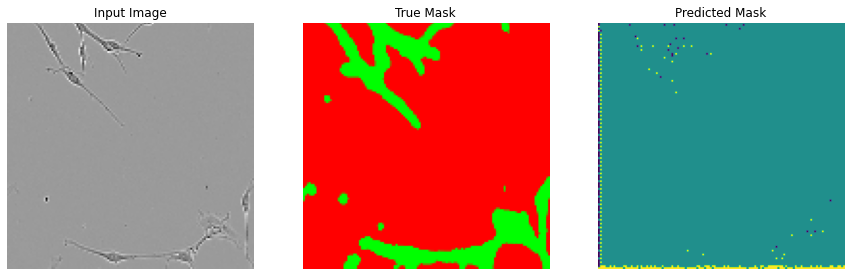

In [13]:
dataset = image_modeling_import.load_dataset_seg(TRAIN_PATH, 2, training = False)

for images, masks in dataset.take(2):
    sample_image, sample_mask = images[1], masks[1]
    #display([sample_image, sample_mask])

show_predictions()

## Train the U-net

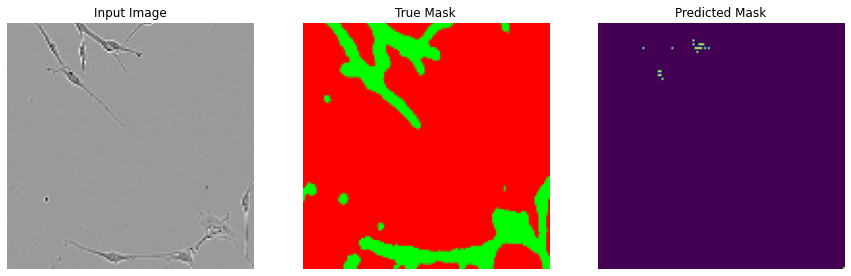


Sample Prediction after epoch 2

10/10 [==============================] - 7s 735ms/step - loss: 0.5680 - accuracy: 0.7437 - val_loss: 0.5657 - val_accuracy: 0.7258


In [14]:
trained_model, results = train_and_evaluate(model, BATCH_SIZE, n_epochs = n_epochs, reinitialize = True)

## Store trained model for later use (more training epochs or prediction on the test set)

In [15]:
!mkdir -p saved_model

model_name = f"{which_cell}_{pretrained_model}_steps_{TRAINING_STEPS * TRAINING_STEPS_MULT}_epochs_{n_epochs}"

trained_model.save(f"saved_model/{model_name}")

2022-02-23 20:10:54.636572: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_model/astro_U-net-from-scratch_steps_10_epochs_2/assets


## Loss/accuracy per epoch figure

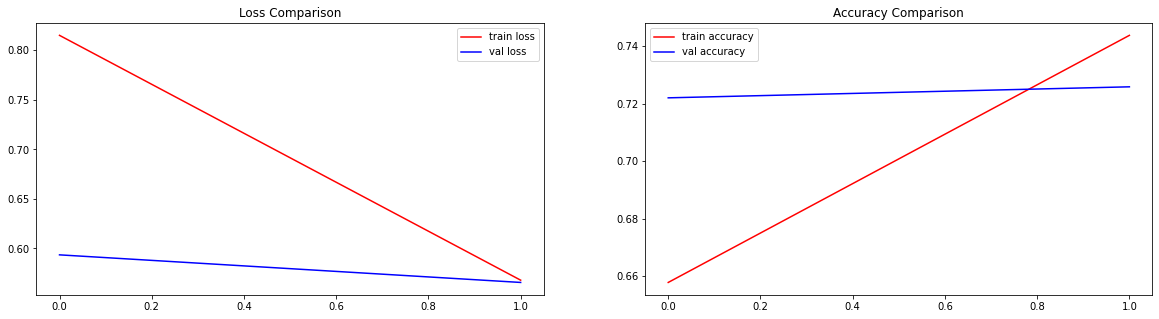

In [16]:
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'val loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'val accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()


!mkdir -p training_history

plt.savefig(f'training_history/{model_name}')

## Load the model and keep on training

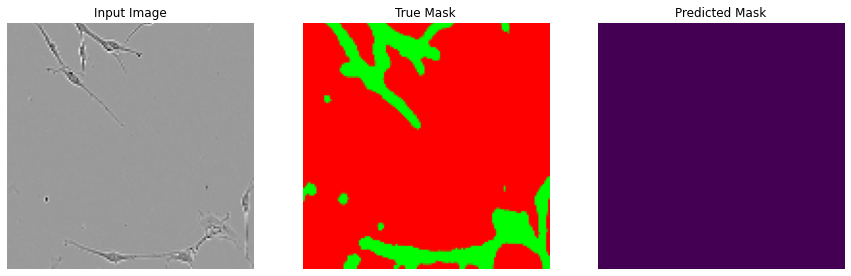


Sample Prediction after epoch 2

10/10 [==============================] - 7s 724ms/step - loss: 0.5722 - accuracy: 0.7401 - val_loss: 0.5774 - val_accuracy: 0.7228
INFO:tensorflow:Assets written to: saved_model/astro_U-net-from-scratch_steps_10_epochs_2+2/assets
astro_U-net-from-scratch_steps_10_epochs_2+2


In [17]:
trained_model = tf.keras.models.load_model(f'saved_model/{model_name}')

trained_model, results = train_and_evaluate(model, BATCH_SIZE, n_epochs = 2)

model_name = model_name +f'+{n_epochs}'
trained_model.save(f'saved_model/{model_name}')

print(model_name)

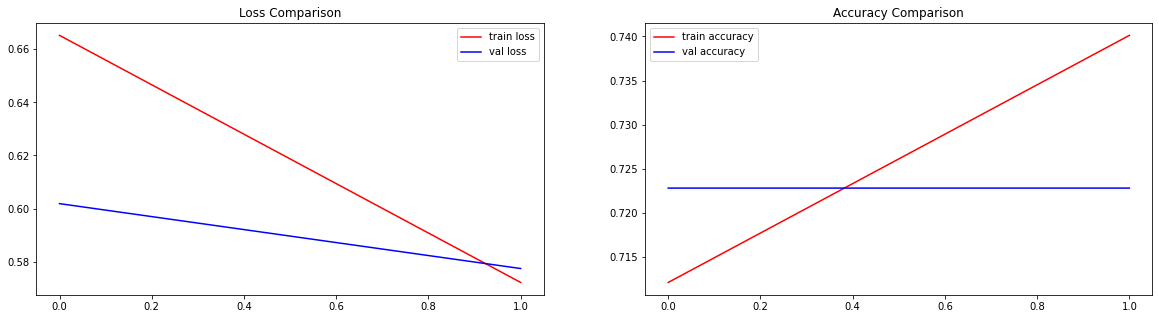

In [18]:
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'val loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'val accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()

plt.savefig(f'training_history/{model_name}')

## Show example predictions

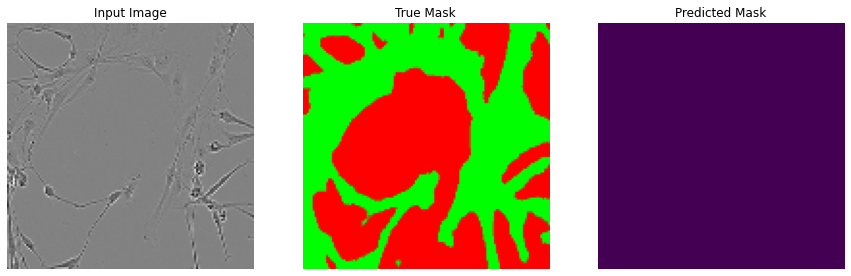

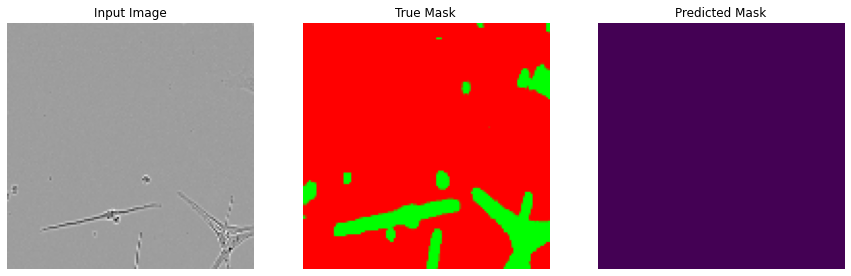

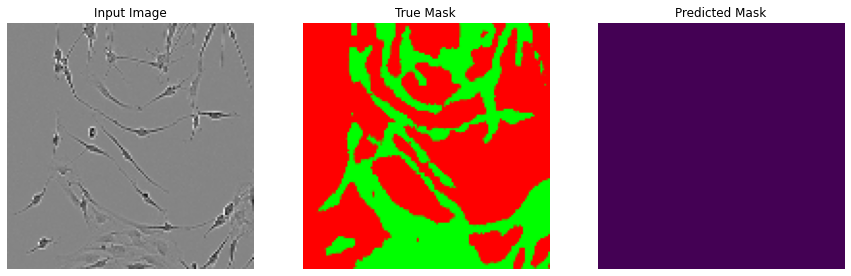

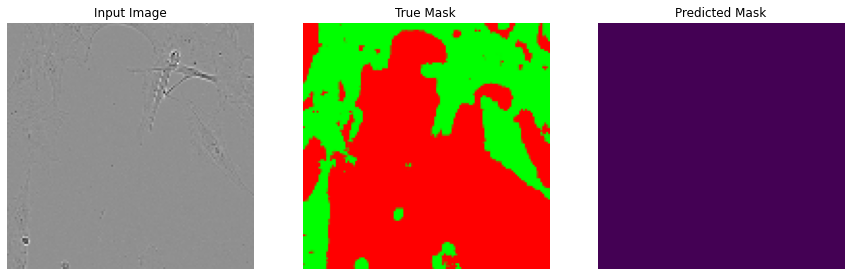

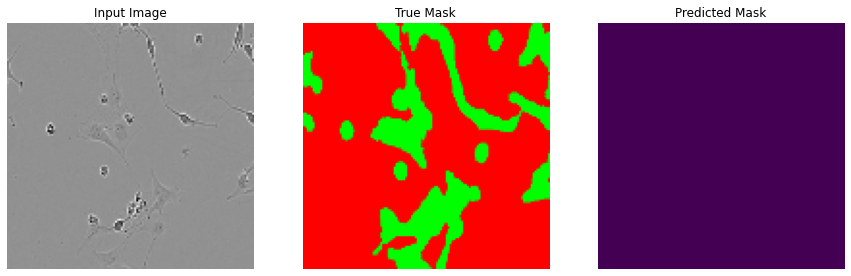

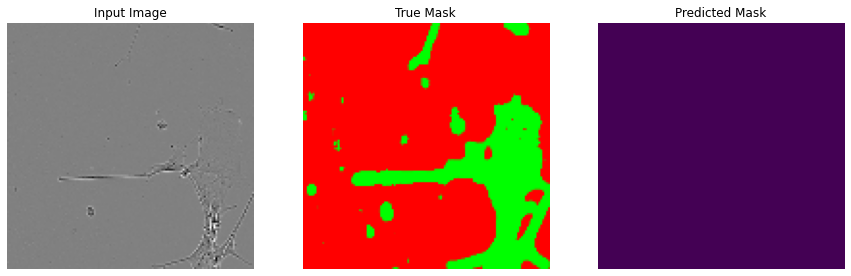

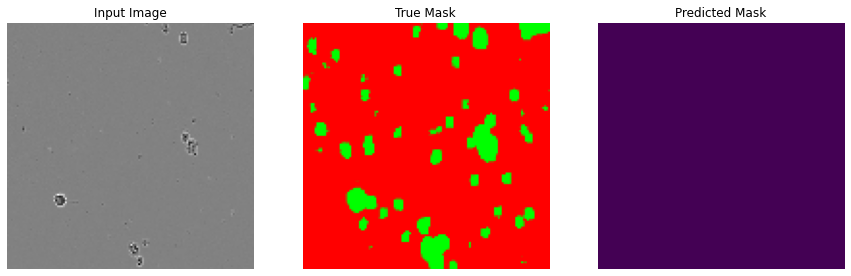

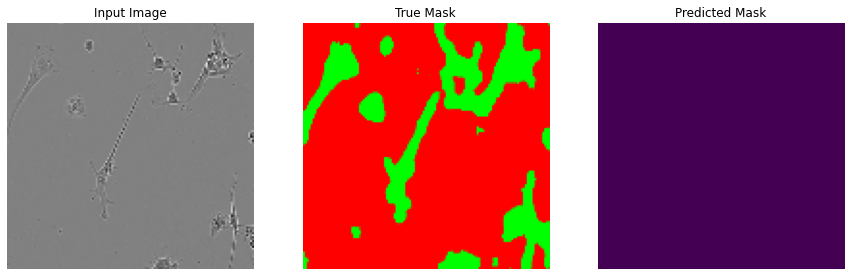

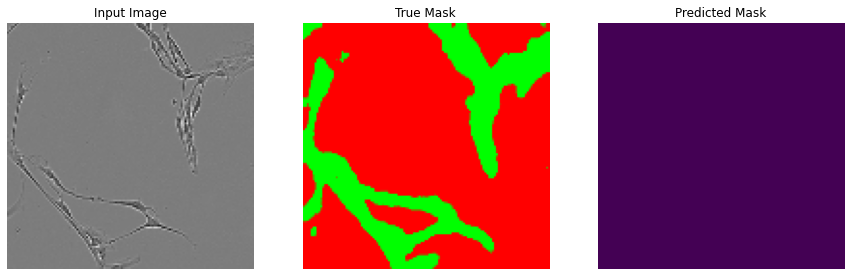

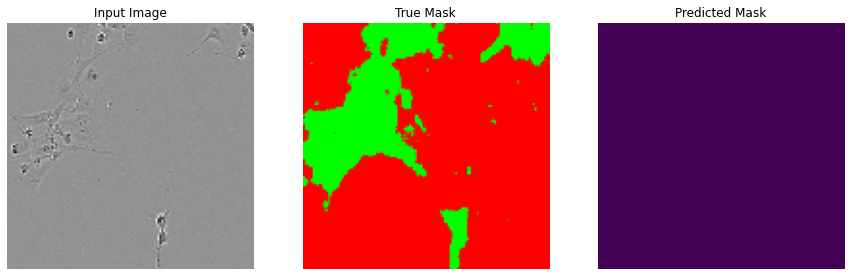

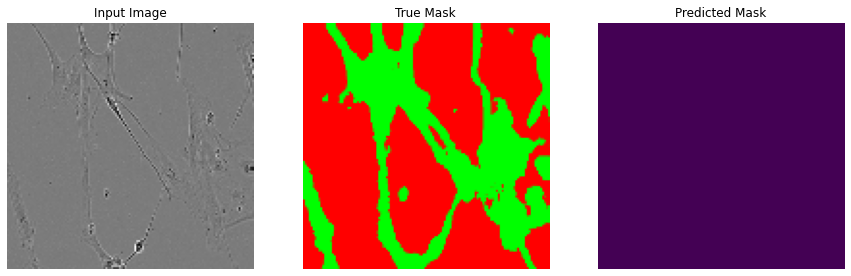

In [19]:
dataset = image_modeling_import.load_dataset_seg(TRAIN_PATH, 32, training = False)

for images, masks in dataset.take(32):
    sample_image, sample_mask = images[0], masks[0]

    show_predictions()